In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 문제
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 17,8

import warnings
warnings.filterwarnings(action='ignore')

# **대구 교통 사고 피해 예측 AI 경진대회 Baseline Code**

## **Fixed Random Seed**  

seed 값에 의해 동일한 코드를 사용해도 결과가 다를 수 있기에, 동일한 결과를 위해 seed 값을 고정시킵니다

In [2]:
import os
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## **데이터 불러오기 및 상위행 확인**  

train.csv, test.csv 파일을 로드하여 상위행을 출력해 봅시다

In [56]:
import pandas as pd
from datetime import datetime

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

## **train, test 데이터 기간 확인하기**  

학습(train) 데이터의 기간과 예측 대상이 되는 test 데이터의 기간을 살펴 봅니다

In [4]:
display(f"train : {train.iloc[0]['사고일시']} ~ {train.iloc[-1]['사고일시']}")
display(f"test : {test.iloc[0]['사고일시']} ~ {test.iloc[-1]['사고일시']}")

'train : 2019-01-01 00 ~ 2021-12-31 23'

'test : 2022-01-01 01 ~ 2022-12-31 21'

### Data Info

In [5]:
#'사고일시' 데이터 타입을 object -> datetime으로  바꾸기
train['사고일시'] = pd.to_datetime(train['사고일시'])
test['사고일시'] = pd.to_datetime(test['사고일시'])

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           39609 non-null  object        
 1   사고일시         39609 non-null  datetime64[ns]
 2   요일           39609 non-null  object        
 3   기상상태         39609 non-null  object        
 4   시군구          39609 non-null  object        
 5   도로형태         39609 non-null  object        
 6   노면상태         39609 non-null  object        
 7   사고유형         39609 non-null  object        
 8   사고유형 - 세부분류  39609 non-null  object        
 9   법규위반         39609 non-null  object        
 10  가해운전자 차종     39609 non-null  object        
 11  가해운전자 성별     39609 non-null  object        
 12  가해운전자 연령     39609 non-null  object        
 13  가해운전자 상해정도   39609 non-null  object        
 14  피해운전자 차종     38618 non-null  object        
 15  피해운전자 성별     38618 non-null  object        
 16  피해운전

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ID      10963 non-null  object        
 1   사고일시    10963 non-null  datetime64[ns]
 2   요일      10963 non-null  object        
 3   기상상태    10963 non-null  object        
 4   시군구     10963 non-null  object        
 5   도로형태    10963 non-null  object        
 6   노면상태    10963 non-null  object        
 7   사고유형    10963 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 685.3+ KB


### - train과 test 데이터셋의  컬럼 수가 서로 다름
    - ID, 사고일시, 요일, 기상상태, 시군구, 도로형태, 노면상태, 사고유형

In [8]:
display(train['요일'].unique())
display(test['요일'].unique())

array(['화요일', '수요일', '목요일', '금요일', '토요일', '일요일', '월요일'], dtype=object)

array(['토요일', '일요일', '월요일', '화요일', '수요일', '목요일', '금요일'], dtype=object)

In [9]:
display(train['기상상태'].unique())
display(test['기상상태'].unique())

array(['맑음', '흐림', '기타', '비', '안개', '눈'], dtype=object)

array(['맑음', '흐림', '기타', '비', '눈'], dtype=object)

***- test에는 기상상태-'안개' 없음***

In [10]:
display(train['시군구'].unique())
display(test['시군구'].unique())

array(['대구광역시 중구 대신동', '대구광역시 달서구 감삼동', '대구광역시 수성구 두산동', '대구광역시 북구 복현동',
       '대구광역시 동구 신암동', '대구광역시 수성구 지산동', '대구광역시 달서구 상인동', '대구광역시 북구 태전동',
       '대구광역시 동구 지묘동', '대구광역시 서구 평리동', '대구광역시 동구 신기동', '대구광역시 서구 상리동',
       '대구광역시 달서구 월성동', '대구광역시 수성구 황금동', '대구광역시 북구 구암동', '대구광역시 동구 신천동',
       '대구광역시 수성구 만촌동', '대구광역시 중구 남산동', '대구광역시 서구 비산동', '대구광역시 북구 침산동',
       '대구광역시 달서구 두류동', '대구광역시 수성구 신매동', '대구광역시 달서구 대곡동', '대구광역시 달성군 유가읍',
       '대구광역시 달성군 논공읍', '대구광역시 동구 율하동', '대구광역시 수성구 시지동', '대구광역시 동구 봉무동',
       '대구광역시 달성군 다사읍', '대구광역시 중구 동산동', '대구광역시 서구 이현동', '대구광역시 남구 이천동',
       '대구광역시 수성구 수성동4가', '대구광역시 북구 노원동3가', '대구광역시 북구 서변동',
       '대구광역시 북구 관음동', '대구광역시 북구 학정동', '대구광역시 수성구 파동', '대구광역시 수성구 상동',
       '대구광역시 달서구 이곡동', '대구광역시 동구 효목동', '대구광역시 북구 읍내동', '대구광역시 중구 남성로',
       '대구광역시 달서구 죽전동', '대구광역시 남구 대명동', '대구광역시 북구 동천동', '대구광역시 동구 지저동',
       '대구광역시 북구 사수동', '대구광역시 중구 덕산동', '대구광역시 달서구 본리동', '대구광역시 동구 용계동',
       '대구광역시 수성구 범어동', '대구광역시 달서구 신당동', '대구광역시 달서구 성당동', '대구광역시 달서구 용산

array(['대구광역시 수성구 상동', '대구광역시 수성구 지산동', '대구광역시 수성구 수성동2가',
       '대구광역시 수성구 신매동', '대구광역시 달서구 감삼동', '대구광역시 중구 달성동', '대구광역시 동구 신암동',
       '대구광역시 서구 평리동', '대구광역시 달서구 송현동', '대구광역시 달서구 두류동', '대구광역시 북구 매천동',
       '대구광역시 달서구 상인동', '대구광역시 달서구 진천동', '대구광역시 중구 삼덕동1가', '대구광역시 중구 동문동',
       '대구광역시 달서구 성당동', '대구광역시 북구 동천동', '대구광역시 북구 태전동', '대구광역시 남구 대명동',
       '대구광역시 달서구 대곡동', '대구광역시 북구 복현동', '대구광역시 달서구 본리동', '대구광역시 수성구 범어동',
       '대구광역시 수성구 황금동', '대구광역시 달서구 호산동', '대구광역시 중구 동인동1가', '대구광역시 남구 이천동',
       '대구광역시 달성군 유가읍', '대구광역시 달서구 월암동', '대구광역시 북구 동호동', '대구광역시 달서구 죽전동',
       '대구광역시 달서구 본동', '대구광역시 달서구 도원동', '대구광역시 달성군 다사읍', '대구광역시 달서구 용산동',
       '대구광역시 달서구 유천동', '대구광역시 북구 산격동', '대구광역시 달서구 파호동', '대구광역시 동구 효목동',
       '대구광역시 북구 고성동3가', '대구광역시 중구 남산동', '대구광역시 동구 지묘동', '대구광역시 달성군 하빈면',
       '대구광역시 서구 내당동', '대구광역시 수성구 매호동', '대구광역시 북구 침산동', '대구광역시 동구 신천동',
       '대구광역시 동구 방촌동', '대구광역시 수성구 두산동', '대구광역시 달성군 구지면', '대구광역시 달서구 대천동',
       '대구광역시 달서구 월성동', '대구광역시 달성군 화원읍', '대구광역시 북구 고성동2가',

In [11]:
display(train['도로형태'].unique())
display(test['도로형태'].unique())
print(train.info())
print(test.info())

array(['단일로 - 기타', '교차로 - 교차로안', '기타 - 기타', '단일로 - 터널', '단일로 - 지하차도(도로)내',
       '단일로 - 교량', '교차로 - 교차로횡단보도내', '주차장 - 주차장', '교차로 - 교차로부근',
       '단일로 - 고가도로위', '미분류 - 미분류'], dtype=object)

array(['교차로 - 교차로안', '단일로 - 기타', '교차로 - 교차로횡단보도내', '교차로 - 교차로부근',
       '단일로 - 지하차도(도로)내', '기타 - 기타', '단일로 - 교량', '단일로 - 고가도로위',
       '주차장 - 주차장', '단일로 - 터널', '미분류 - 미분류'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           39609 non-null  object        
 1   사고일시         39609 non-null  datetime64[ns]
 2   요일           39609 non-null  object        
 3   기상상태         39609 non-null  object        
 4   시군구          39609 non-null  object        
 5   도로형태         39609 non-null  object        
 6   노면상태         39609 non-null  object        
 7   사고유형         39609 non-null  object        
 8   사고유형 - 세부분류  39609 non-null  object        
 9   법규위반         39609 non-null  object        
 10  가해운전자 차종     39609 non-null  object        
 11  가해운전자 성별     39609 non-null  object        
 12  가해운전자 연령     39609 non-null  object        
 13  가해운전자 상해정도   39609 non-null  object        
 14  피해운전자 차종     38618 non-null  object        
 15  피해운전자 성별     38618 non-null  object        
 16  피해운전

In [12]:
display(train['노면상태'].unique())
display(test['노면상태'].unique())

array(['건조', '젖음/습기', '서리/결빙', '기타', '침수', '적설'], dtype=object)

array(['건조', '젖음/습기', '서리/결빙', '기타', '침수', '적설'], dtype=object)

In [13]:
display(train['사고유형'].unique())
display(test['사고유형'].unique())

array(['차대사람', '차대차', '차량단독'], dtype=object)

array(['차대사람', '차대차', '차량단독'], dtype=object)

# 노면상태, 사고유형 엔코딩

In [14]:
#데이터 init
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')
data = pd.concat([train, test], sort=False)
data.info()
print(data.columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50572 entries, 0 to 10962
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           50572 non-null  object 
 1   사고일시         50572 non-null  object 
 2   요일           50572 non-null  object 
 3   기상상태         50572 non-null  object 
 4   시군구          50572 non-null  object 
 5   도로형태         50572 non-null  object 
 6   노면상태         50572 non-null  object 
 7   사고유형         50572 non-null  object 
 8   사고유형 - 세부분류  39609 non-null  object 
 9   법규위반         39609 non-null  object 
 10  가해운전자 차종     39609 non-null  object 
 11  가해운전자 성별     39609 non-null  object 
 12  가해운전자 연령     39609 non-null  object 
 13  가해운전자 상해정도   39609 non-null  object 
 14  피해운전자 차종     38618 non-null  object 
 15  피해운전자 성별     38618 non-null  object 
 16  피해운전자 연령     38618 non-null  object 
 17  피해운전자 상해정도   38618 non-null  object 
 18  사망자수         39609 non-null  float64
 19  중상자수     

# 사고유형, 노면상태-Label encoding

In [15]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# "사고유형" 컬럼 Label Encoding
data['사고유형_encoded'] = label_encoder.fit_transform(data['사고유형'])

# "노면상태" 컬럼 Label Encoding
data['노면상태_encoded'] = label_encoder.fit_transform(data['노면상태'])

# 결과 확인
print(data[['사고유형', '사고유형_encoded', '노면상태', '노면상태_encoded']])


       사고유형  사고유형_encoded 노면상태  노면상태_encoded
0      차대사람             0   건조             0
1      차대사람             0   건조             0
2      차대사람             0   건조             0
3       차대차             1   건조             0
4       차대차             1   건조             0
...     ...           ...  ...           ...
10958   차대차             1   건조             0
10959   차대차             1   건조             0
10960   차대차             1   건조             0
10961   차대차             1   건조             0
10962   차대차             1   건조             0

[50572 rows x 4 columns]


# 사고유형, 노면상태-One-Hot Encoding

In [16]:
# "사고유형" 및 "노면상태" 컬럼을 원-핫 인코딩
data_encoded = pd.get_dummies(data, columns=['사고유형', '노면상태'])
train_encoded = pd.get_dummies(train, columns=['사고유형', '노면상태'])
# 결과 확인
print(data_encoded.info())

<class 'pandas.core.frame.DataFrame'>
Index: 50572 entries, 0 to 10962
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            50572 non-null  object 
 1   사고일시          50572 non-null  object 
 2   요일            50572 non-null  object 
 3   기상상태          50572 non-null  object 
 4   시군구           50572 non-null  object 
 5   도로형태          50572 non-null  object 
 6   사고유형 - 세부분류   39609 non-null  object 
 7   법규위반          39609 non-null  object 
 8   가해운전자 차종      39609 non-null  object 
 9   가해운전자 성별      39609 non-null  object 
 10  가해운전자 연령      39609 non-null  object 
 11  가해운전자 상해정도    39609 non-null  object 
 12  피해운전자 차종      38618 non-null  object 
 13  피해운전자 성별      38618 non-null  object 
 14  피해운전자 연령      38618 non-null  object 
 15  피해운전자 상해정도    38618 non-null  object 
 16  사망자수          39609 non-null  float64
 17  중상자수          39609 non-null  float64
 18  경상자수          39609 non-null  f

# 데이터 시각화

## 사고 유형별 빈도

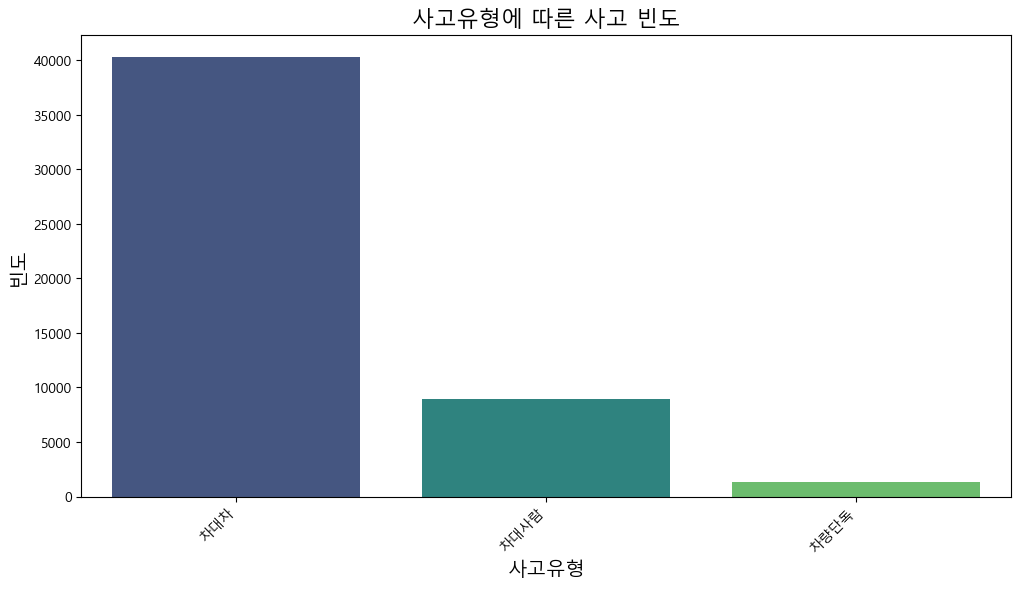

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 사고유형에 따른 사망자, 중상자, 경상자, 부상자 수의 평균 계산
grouped_data = data_encoded.groupby('사고유형_encoded').agg({
    '사망자수': 'mean',
    '중상자수': 'mean',
    '경상자수': 'mean',
    '부상자수': 'mean'
}).reset_index()

# Seaborn의 countplot을 사용하여 각 사고유형의 빈도를 시각화 (내림차순 정렬)
plt.figure(figsize=(12, 6))
sns.countplot(x='사고유형_encoded', data=data_encoded, palette='viridis', order=data_encoded['사고유형_encoded'].value_counts().index)
plt.title('사고유형에 따른 사고 빈도', fontsize=16)
plt.xlabel('사고유형', fontsize=14)
plt.ylabel('빈도', fontsize=14)
plt.xticks([0, 1, 2], ['차대차', '차대사람', '차량단독'], rotation=45, ha='right')
# 그래프 표시
plt.show()


## 사고 유형별 부상정도 선 그래프

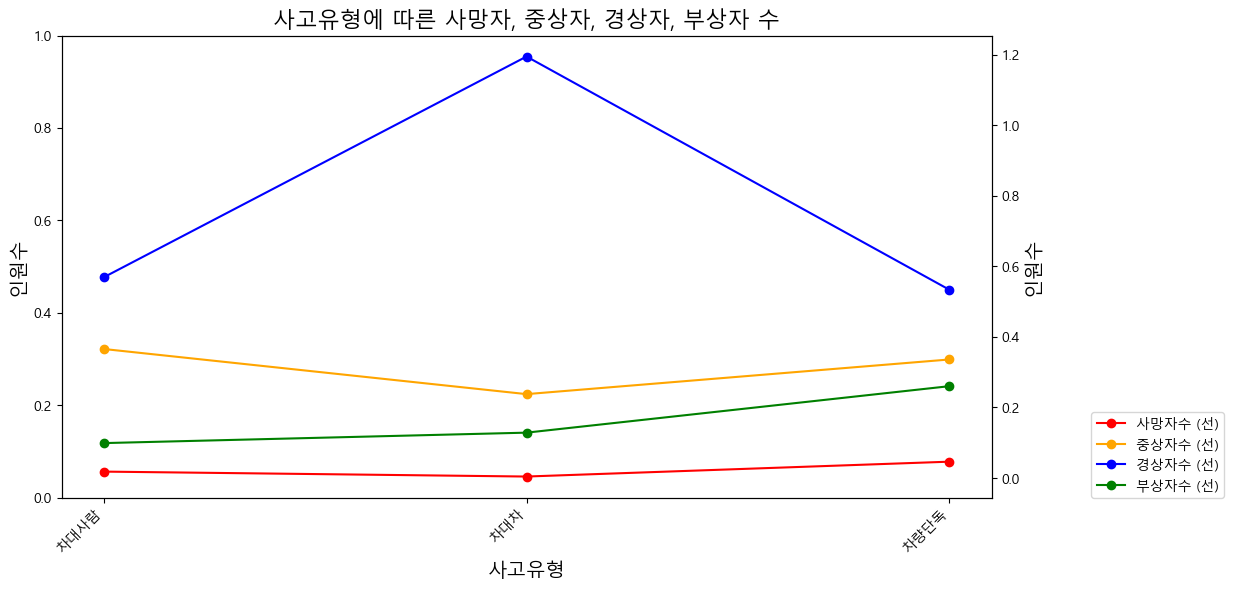

In [18]:
# 사고유형에 따른 사망자, 중상자, 경상자, 부상자 수의 평균 계산
grouped_data = data_encoded.groupby('사고유형_encoded').agg({
    '사망자수': 'mean',
    '중상자수': 'mean',
    '경상자수': 'mean',
    '부상자수': 'mean'
}).reset_index()

# 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

# 꺽은선 그래프 (사망자, 중상자, 경상자, 부상자)
ax2 = ax1.twinx()
ax2.plot(grouped_data['사고유형_encoded'], grouped_data['사망자수'], marker='o', linestyle='-', color='red', label='사망자수 (선)')
ax2.plot(grouped_data['사고유형_encoded'], grouped_data['중상자수'], marker='o', linestyle='-', color='orange', label='중상자수 (선)')
ax2.plot(grouped_data['사고유형_encoded'], grouped_data['경상자수'], marker='o', linestyle='-', color='Blue', label='경상자수 (선)')
ax2.plot(grouped_data['사고유형_encoded'], grouped_data['부상자수'], marker='o', linestyle='-', color='green', label='부상자수 (선)')

# 그래프 제목과 레이블
plt.title('사고유형에 따른 사망자, 중상자, 경상자, 부상자 수', fontsize=16)
ax1.set_xlabel('사고유형', fontsize=14)
ax1.set_ylabel('인원수', fontsize=14, color='black')
ax2.set_ylabel('인원수', fontsize=14, color='black')

ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.2))

# x축 값 설정
ax1.set_xticks(grouped_data['사고유형_encoded'])
ax1.set_xticklabels(['차대사람', '차대차', '차량단독'], rotation=45, ha='right')

# 그래프 표시
plt.show()

In [19]:
grouped_data.iloc[[0, 1]] = grouped_data.iloc[[1, 0]].to_numpy()
print(grouped_data)

   사고유형_encoded      사망자수      중상자수      경상자수      부상자수
0             1  0.004310  0.237848  1.194526  0.128677
1             0  0.018294  0.365725  0.569003  0.099078
2             2  0.046418  0.336024  0.533804  0.260343


## 사고 유형별 부상정도 막대그래프

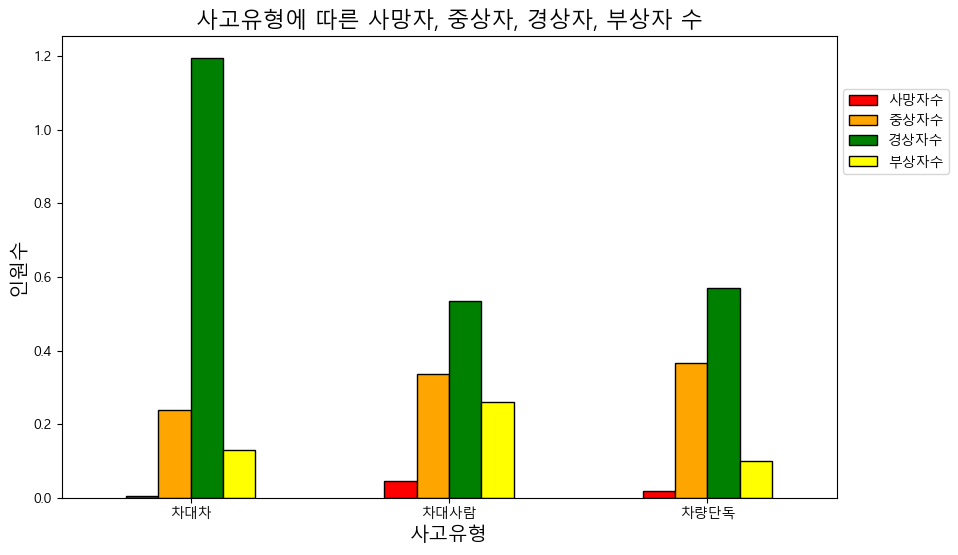

In [26]:

import seaborn as sns

grouped_data['합계'] = grouped_data[['사망자수', '중상자수', '경상자수', '부상자수']].sum(axis=1)

grouped_data_sorted = grouped_data.sort_values(by='합계', ascending=False)

custom_labels = ['차대차', '차대사람', '차량단독']
custom_colors = ['red', 'orange', 'green', 'yellow']

fig, ax = plt.subplots(figsize=(10, 6))
grouped_data_sorted.plot(kind='bar', x='사고유형_encoded', y=['사망자수', '중상자수', '경상자수', '부상자수'], ax=ax, edgecolor='black', color=custom_colors)
plt.title('사고유형에 따른 사망자, 중상자, 경상자, 부상자 수', fontsize=16)
plt.xlabel('사고유형', fontsize=14)
plt.ylabel('인원수', fontsize=14, color='black')

plt.legend(['사망자수', '중상자수', '경상자수', '부상자수'], loc='upper left', bbox_to_anchor=(1, 0.9))
plt.xticks(range(len(custom_labels)), custom_labels, rotation=0)
plt.show()

## 노면 상태에 따른 부상정도 그래프

    노면상태      경상자수      중상자수      부상자수      사망자수
0     건조  1.071472  0.259583  0.126963  0.007359
1     기타  0.637931  0.344828  0.103448  0.034483
2  서리/결빙  0.880000  0.240000  0.320000  0.000000
3     적설  1.000000  0.000000  0.000000  0.000000
4  젖음/습기  1.063871  0.294194  0.124516  0.011935
5     침수  0.666667  0.000000  0.333333  0.333333


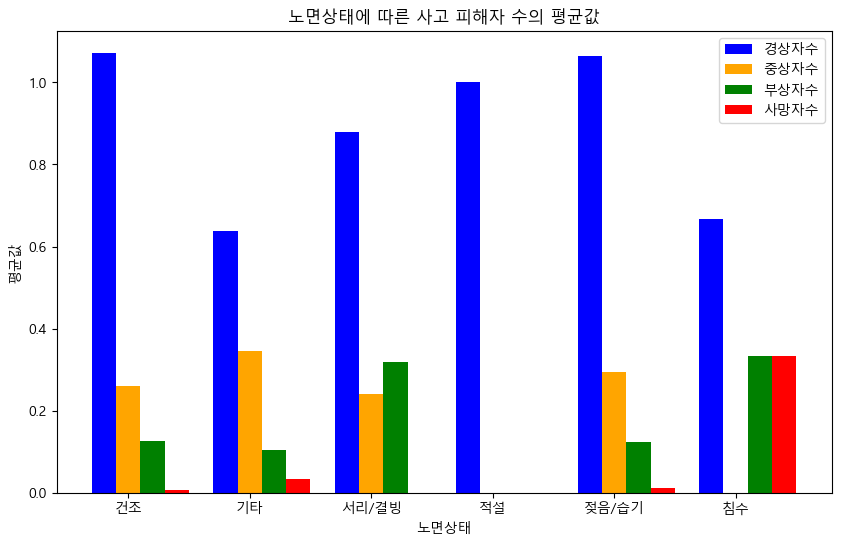

In [29]:
import pandas as pd

# 데이터프레임에서 필요한 열만 추출
subset_df = train[['노면상태', '경상자수', '중상자수', '부상자수', '사망자수']]
# '노면상태'로 그룹화하고 각 그룹에 대한 평균값 계산
grouped_df = subset_df.groupby('노면상태').mean().reset_index()

# 결과를 출력
print(grouped_df)
# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 막대 그래프 생성
bar_width = 0.2
bar_positions = range(len(grouped_df))
bar_colors = ['blue', 'orange', 'green', 'red']

for i, column in enumerate(['경상자수', '중상자수', '부상자수', '사망자수']):
    ax.bar(
        x=[pos + bar_width * i for pos in bar_positions],
        height=grouped_df[column],
        width=bar_width,
        label=column,
        color=bar_colors[i]
    )
ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(grouped_df['노면상태'])
ax.set_xlabel('노면상태')
ax.set_ylabel('평균값')
ax.set_title('노면상태에 따른 사고 피해자 수의 평균값')
# 범례 표시
ax.legend()
# 그래프 출력
plt.show()

## 노면상태에 따른 ECLO 시각화

In [30]:
subset_df

,노면상태,경상자수,중상자수,부상자수,사망자수
0,건조,0,1,0,0
1,건조,1,0,0,0
2,건조,1,0,0,0
3,건조,0,1,0,0
4,건조,1,0,0,0
...,...,...,...,...,...
39604,건조,1,0,0,0
39605,건조,1,0,0,0
39606,건조,0,2,0,0
39607,건조,1,0,0,0


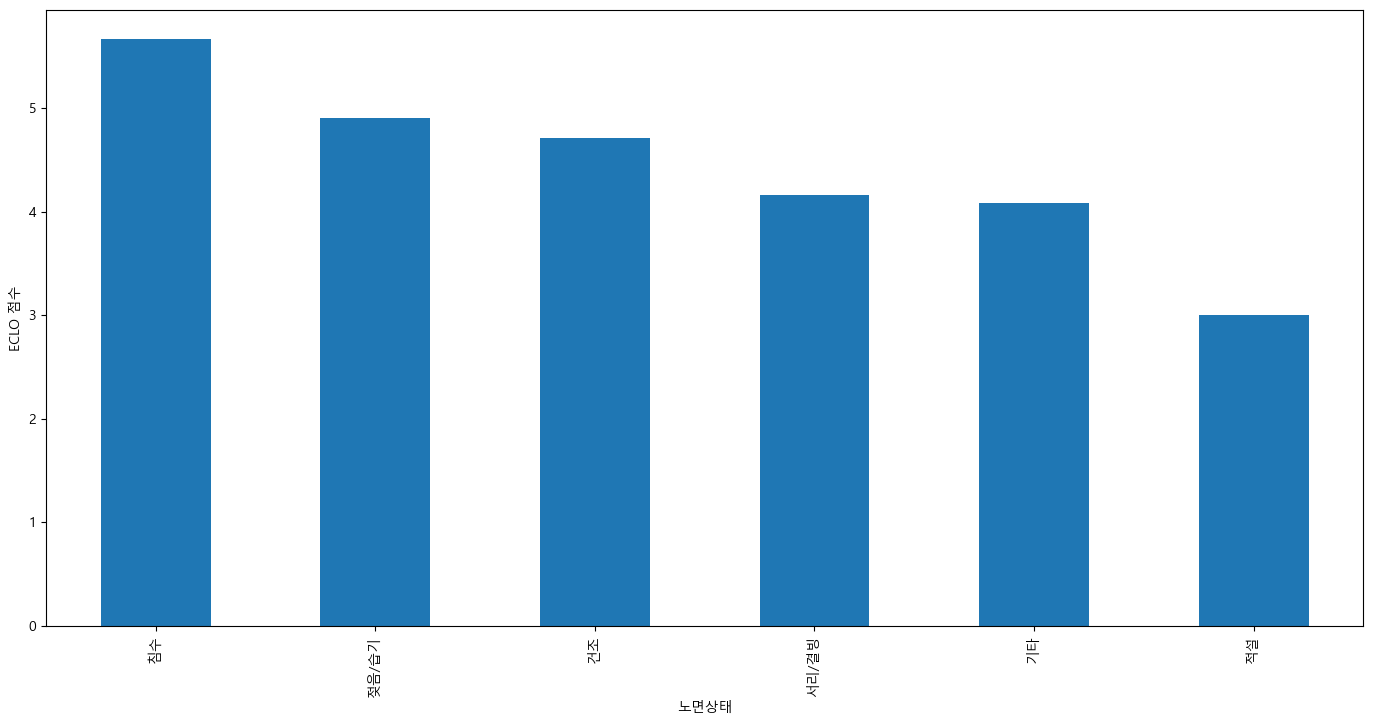

In [51]:
# 노면상태별 ECLO 점수 평균 계산
road_condition_eclo = train.groupby("노면상태")["ECLO"].mean()
road_condition_eclo = road_condition_eclo.sort_values(ascending=False)
# 그래프 그리기

road_condition_eclo.plot.bar()
plt.xlabel("노면상태")
plt.ylabel("ECLO 점수")
plt.show()


## 사고 유형에 따른 ECLO 시각화

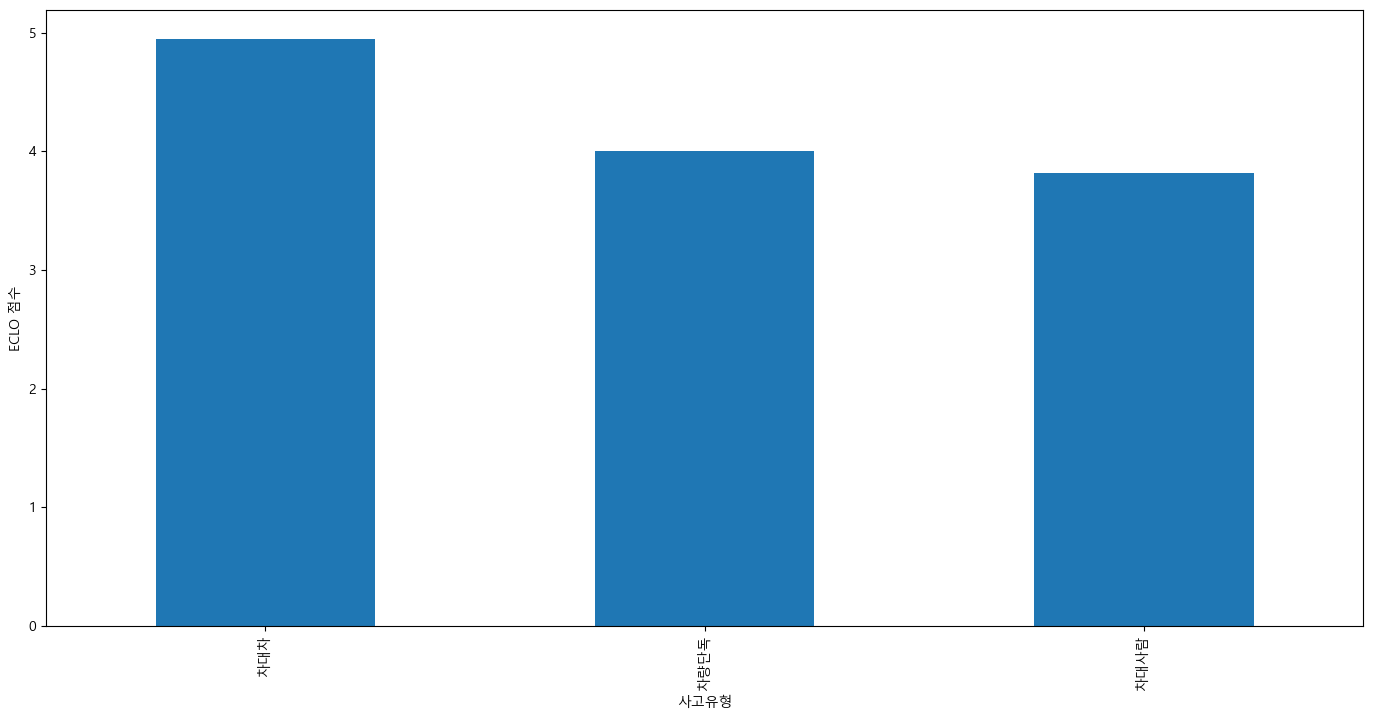

In [43]:
# 노면상태별 ECLO 점수 평균 계산
accident_type_eclo = train.groupby("사고유형")["ECLO"].mean()
accident_type_eclo = accident_type_eclo.sort_values(ascending=False)
# 그래프 그리기

accident_type_eclo.plot.bar()
plt.xlabel("사고유형")
plt.ylabel("ECLO 점수")
plt.show()

# 전처리한 데이터로 선형회귀

In [22]:
# "사고유형" 및 "노면상태" 컬럼을 원-핫 인코딩 다시하는이유: test에는 eclo가 없는데 학습이 되나?
train_encoded = pd.get_dummies(train, columns=['사고유형', '노면상태'])

# "사고유형"으로 시작하는 컬럼과 "노면상태"로 시작하는 컬럼 및 "ECLO" 컬럼을 선택
selected_columns = train_encoded.filter(regex='^사고유형_|^노면상태_|^ECLO$', axis=1)

print(selected_columns.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ECLO        39609 non-null  int64
 1   사고유형_차대사람   39609 non-null  bool 
 2   사고유형_차대차    39609 non-null  bool 
 3   사고유형_차량단독   39609 non-null  bool 
 4   노면상태_건조     39609 non-null  bool 
 5   노면상태_기타     39609 non-null  bool 
 6   노면상태_서리/결빙  39609 non-null  bool 
 7   노면상태_적설     39609 non-null  bool 
 8   노면상태_젖음/습기  39609 non-null  bool 
 9   노면상태_침수     39609 non-null  bool 
dtypes: bool(9), int64(1)
memory usage: 657.7 KB
None


In [23]:
# RMSLE, MSE로 성능확인
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 독립 변수(X)와 종속 변수(y) 설정
X = selected_columns.drop('ECLO', axis=1)
y = selected_columns['ECLO']

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 생성
model = LinearRegression()

# 모델 훈련
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# RMSLE 계산
rmsle = mean_squared_log_error(y_test, y_pred, squared=False)

# 결과 출력
print(f'RMSLE: {rmsle}')

mse = mean_squared_error(y_test, y_pred)
print(f'RMSLE: {mse}')

r2 = r2_score(y_test, y_pred)
print(f'RMSLE: {r2}')

RMSLE: 0.4641459750686722
RMSLE: 9.779149067323637
RMSLE: 0.0170830853071261


# train데이터 알고리즘 분석해보기

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 데이터 전처리
le = LabelEncoder()
df_encoded = train.copy()
for column in df_encoded.columns:
    if df_encoded[column].dtype == 'object':
        df_encoded[column] = le.fit_transform(df_encoded[column])

# 종속변수와 특성 설정
X = df_encoded.drop(['ECLO'], axis=1)
y = df_encoded['ECLO']

# 학습용과 테스트용 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 머신러닝 알고리즘 선택 및 학습
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('\nClassification Report:\n', classification_report_result)


Accuracy: 0.47336531178995206

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       531
           2       0.00      0.00      0.00        26
           3       0.47      1.00      0.64      3750
           4       0.00      0.00      0.00       152
           5       0.00      0.00      0.00      1326
           6       0.00      0.00      0.00      1008
           7       0.00      0.00      0.00        51
           8       0.00      0.00      0.00       243
           9       0.00      0.00      0.00       290
          10       0.00      0.00      0.00       130
          11       0.00      0.00      0.00        81
          12       0.00      0.00      0.00       115
          13       0.00      0.00      0.00        43
          14       0.00      0.00      0.00        23
          15       0.00      0.00      0.00        57
          16       0.00      0.00      0.00        21
          17       0.00   

### 날짜 데이터 파싱하기

In [24]:

train['year'] = train.사고일시.dt.year
train['month'] = train.사고일시.dt.month
train['day'] = train.사고일시.dt.day
train['hour'] = train.사고일시.dt.hour

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
test['year'] = test.사고일시.dt.year
test['month'] = test.사고일시.dt.month
test['day'] = test.사고일시.dt.day
test['hour'] = test.사고일시.dt.hour

## **데이터 전처리**  

현재 '사고일시', '시군구', '도로형태' 컬럼은 반복되는 패턴으로 여러 정보를 포함하고 있습니다
이런 반복되는 패턴을 일반화하면 pandas에서 제공하는 str.extract를 통해 한 번에 추출 가능합니다  

## **파생 변수 생성 1 : 날짜, 시간정보 생성**

'사고일시' 컬럼으로 부터 연도, 월, 일, 시간 정보 추출 및 변환 합니다

In [ ]:
import pandas as pd
from datetime import datetime

train_org = pd.read_csv('./open/train.csv')
test_org = pd.read_csv('./open/test.csv')

display(train_org.head())
display(test_org.tail())

In [ ]:
train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

## **파생 변수 생성 2 : 공간(위치) 정보 생성**

'시군구' 컬럼으로부터 의미 있는 공산 정보를 추출 및 변환 합니다

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

## **파생 변수 추출 3 : 도로 형태 정보 추출**  

'도로형태' 컬럼은 '단일로 - 기타'와 같은 패턴으로 구성되어 있습니다. 이를 두종류의 독립된 정보로 보고 두개의 컬럼으로 분리하여 생성합니다.

In [ ]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

## train, test 컬럼 수 맞추기

test에 있는 컬럼들만 사용하여 train 데이터를 구성했습니다.

In [ ]:
train_df= train_df[['ID','요일','기상상태','노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구','동', '도로형태1', '도로형태2']]
train_df

## **전처리 결과 확인**

지금까지 전처리한 결과를 확인해 봅시다

In [ ]:
display(train_df.head())
display(test_df.head())

In [ ]:
# train과 test 데이터 합치기
data = pd.concat([train_df, test_df], sort=False)
data.info()